In [1]:
import torch
import numpy as np
import random
from sctfbridge.model import scTFBridge

def set_seed(seed):
    import os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.set_float32_matmul_precision('high')


set_seed(3407)

In [2]:
import anndata
dataset_name = 'human_PBMC'
cell_key = 'cell_type'
batch_key = ''


gex_data = anndata.read_h5ad(f'filter_data/{dataset_name}/RNA_filter.h5ad')
atac_adata = anndata.read_h5ad(f'filter_data/{dataset_name}/ATAC_filter.h5ad')
TF_adata = anndata.read_h5ad(f'filter_data/{dataset_name}/TF_filter.h5ad')
mask_path = f'filter_data/{dataset_name}/TF_binding/TF_binding.txt'

In [3]:
new_model = scTFBridge.load('sctfbridge_model', device=torch.device('cuda:7'))


🚀 Loading model from sctfbridge_model...
  - Using device: cuda:7
✅ Model loaded and ready for inference.


In [4]:
rna_recon = new_model.predict_cross_omics(
    atac_adata,
    'RNA'
)

🧬 Starting cross-omics prediction: ATAC -> RNA...
  - Using device: cuda:7
  - Preparing data loader for prediction...


Predicting: 100%|██████████| 76/76 [00:03<00:00, 23.83batch/s]


✅ Cross-omics prediction complete. Returning generated RNA matrix.


In [5]:
gex_data.obsm['rna_recon'] = rna_recon

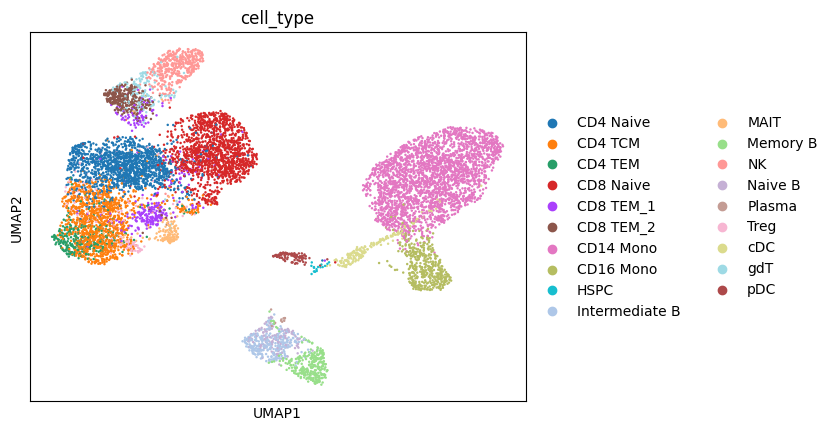

In [6]:
import scanpy as sc

sc.pp.neighbors(gex_data, use_rep='rna_recon')
sc.tl.umap(gex_data)
sc.pl.umap(gex_data,
           color=['cell_type'])

In [7]:
recon_adata = sc.AnnData(X=gex_data.obsm['rna_recon'],
                         obs=gex_data.obs.copy(),
                         var=gex_data.var.copy())


--- Original marker gene expression Heatmap ---


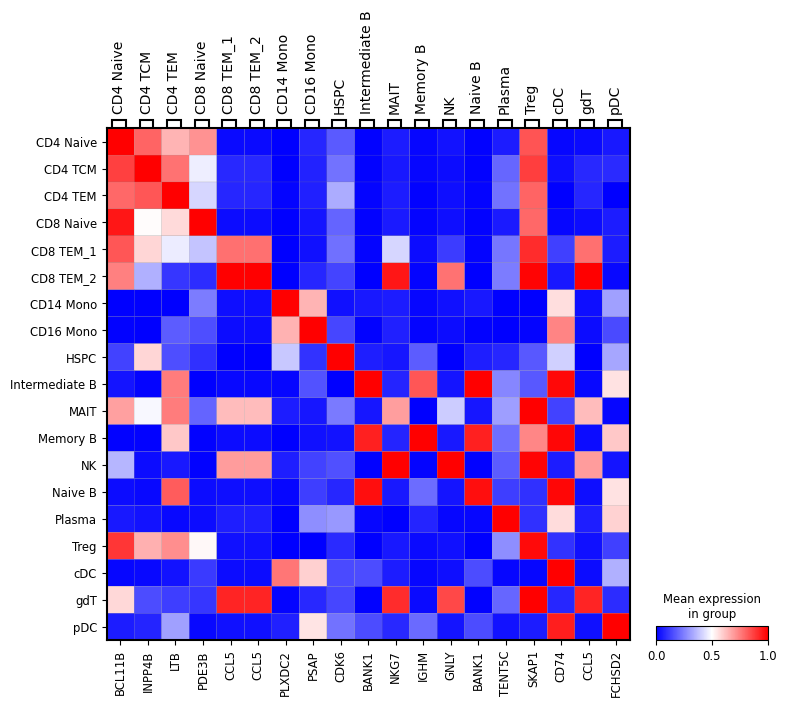


--- Reconstructed marker gene expression Heatmap ---


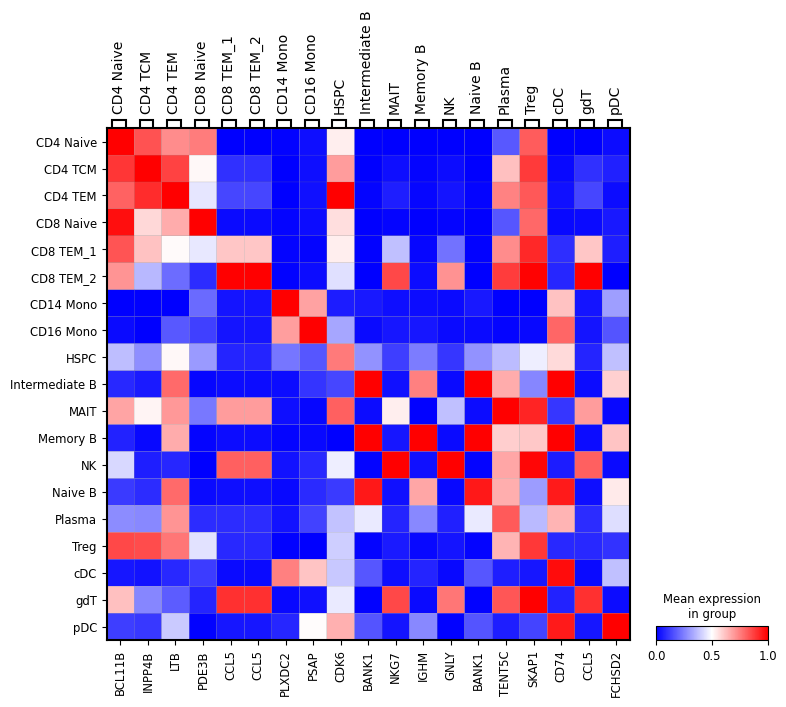

In [8]:
sc.tl.rank_genes_groups(gex_data, groupby='cell_type', method='t-test')
# marker gene
marker_genes_dict = {
    cell_type: gex_data.uns['rank_genes_groups']['names'][cell_type][:1]
    for cell_type in gex_data.obs['cell_type'].cat.categories
}


print("--- Original marker gene expression Heatmap ---")
sc.pl.matrixplot(gex_data,
                  marker_genes_dict,
                  groupby='cell_type',
                  standard_scale='var',
                  cmap='bwr',
                  show=True)

print("\n--- Reconstructed marker gene expression Heatmap ---")
sc.pl.matrixplot(recon_adata,
                  marker_genes_dict,
                  groupby='cell_type',
                  standard_scale='var',
                  cmap='bwr',
                  show=True)